In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [3]:
import pandas as pd

# Lire le fichier texte en précisant le séparateur (',' ici, à adapter selon ton fichier)
df = pd.read_csv("household_power_consumption.txt")  # Utilise '\t' si c'est une tabulation

# Sauvegarder en CSV
df.to_csv("household_power_consumption1.csv", index=False)

print("Conversion terminée : household_power_consumption.csv est créé !")

Conversion terminée : household_power_consumption.csv est créé !


In [4]:
# To load the dataset correctly (fixing the separator issue)
df = pd.read_csv("household_power_consumption1.csv", sep=";")  # Now columns are separated properly
df.head()

C:\Users\DELL 3510\AppData\Local\Temp\ipykernel_11712\1170426670.py:2: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("household_power_consumption1.csv", sep=";")  # Now columns are separated properly


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [5]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


,Sub_metering_3
count,2.049280e+06
mean,6.458447e+00
std,8.437154e+00
min,0.000000e+00
25%,0.000000e+00
50%,1.000000e+00
75%,1.700000e+01
max,3.100000e+01


In [6]:
# Vérifier les valeurs manquantes par colonne
missing_values = df.isnull().sum()
# Afficher uniquement les colonnes qui ont des valeurs manquantes
missing_columns = missing_values[missing_values > 0]
print("Colonnes avec des valeurs manquantes :\n", missing_columns)

Colonnes avec des valeurs manquantes :
 Sub_metering_3    25979
dtype: int64


In [7]:
df["Sub_metering_3"].fillna(df["Sub_metering_3"].mean(), inplace=True)

In [8]:
print(df.isnull().sum())

Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


In [9]:
# Convertir "Date" et "Time" en un seul format datetime
df["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], errors="coerce")

# Supprimer les anciennes colonnes "Date" et "Time" si nécessaire
df = df.drop(columns=["Date", "Time"])

# Convertir les colonnes numériques (sauf Sub_metering_3 qui est déjà en float64)
colonnes_numeriques = [
    "Global_active_power", "Global_reactive_power", 
    "Voltage", "Global_intensity", "Sub_metering_1", "Sub_metering_2"
]

# Conversion en float, avec "coerce" pour gérer les erreurs (valeurs non numériques deviennent NaN)
df[colonnes_numeriques] = df[colonnes_numeriques].apply(pd.to_numeric, errors="coerce")

# Vérifier que tout est bien converti
print(df.dtypes)


C:\Users\DELL 3510\AppData\Local\Temp\ipykernel_11712\1053913652.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], errors="coerce")


Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
Datetime                 datetime64[ns]
dtype: object


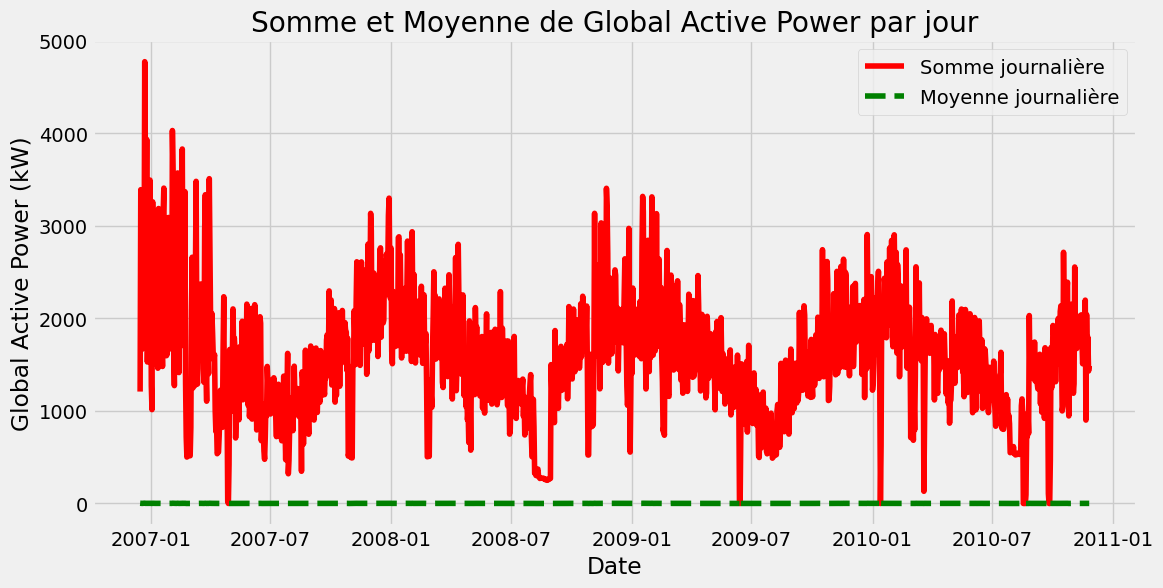

In [10]:

# Rééchantillonner par jour
daily_sum = df.resample("D", on="Datetime")["Global_active_power"].sum()
daily_mean = df.resample("D", on="Datetime")["Global_active_power"].mean()
# Tracer les courbes
plt.figure(figsize=(12, 6))

# Tracer la somme
plt.plot(daily_sum, label="Somme journalière", color="red")

# Tracer la moyenne
plt.plot(daily_mean, label="Moyenne journalière", color="green", linestyle="--")

# Ajouter des labels et un titre
plt.xlabel("Date")
plt.ylabel("Global Active Power (kW)")
plt.title("Somme et Moyenne de Global Active Power par jour")
plt.legend()
plt.grid(True)

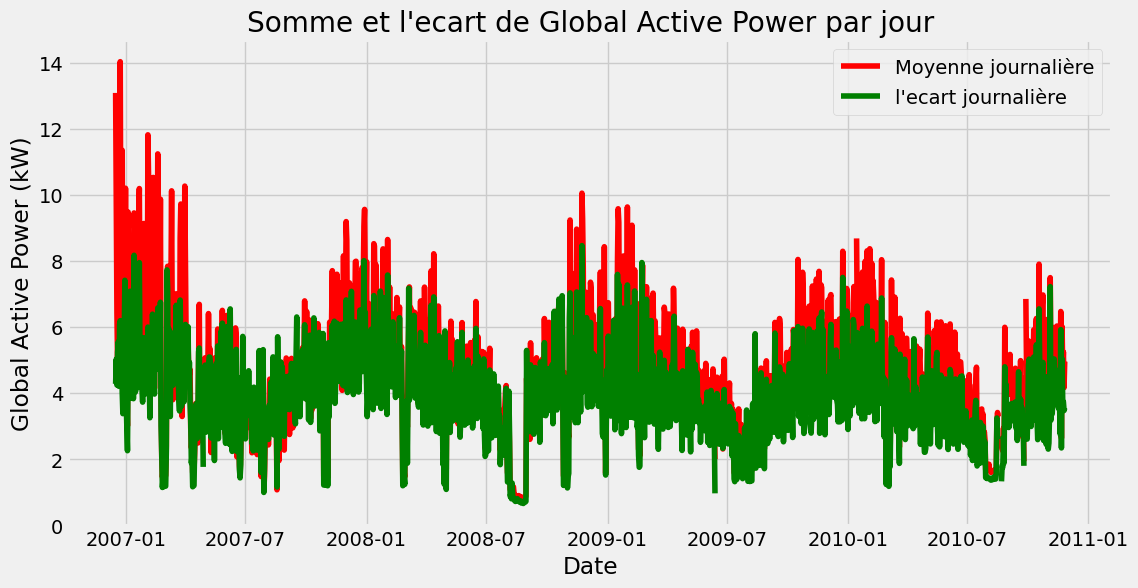

In [42]:

# Rééchantillonnage par jour ('D')
daily_sum2 = df.resample("D", on="Datetime")["Global_intensity"].sum()
daily_mean2 = df.resample("D", on="Datetime")["Global_intensity"].mean()
daily_std2 = df.resample("D", on="Datetime")["Global_intensity"].std()

# Tracer les courbes
plt.figure(figsize=(12, 6))

# Tracer la somme
plt.plot(daily_mean2, label="Moyenne journalière", color="red")

# Tracer la moyenne
plt.plot(daily_std2, label="l'ecart journalière", color="green")

# Ajouter des labels et un titre
plt.xlabel("Date")
plt.ylabel("Global Active Power (kW)")
plt.title("Somme et l'ecart de Global Active Power par jour")
plt.legend()
plt.grid(True)



In [32]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [11]:

#Charger les données
target_column = 'Global_active_power'
df = df[['Datetime', target_column]].set_index('Datetime')

# Normalisation des données 
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# Création des séquences temporelles pour LSTM
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])  # Séquence de 10 valeurs
        y.append(data[i+seq_length])    # Valeur cible (suivante)
    return np.array(X), np.array(y)

# Transformer les données en séquences temporelleS
seq_length = 10  # 10 pas de temps
X, y = create_sequences(df_scaled, seq_length)

# Diviser en ensemble d'entraînement et de test (80% - 20%)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Vérification des dimensions
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
# Définition du modèle séquentiel
model = Sequential()

# Première couche LSTM avec 50 neurones, retour des séquences pour la couche suivante
model.add(LSTM(20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Pour éviter le surajustement

# Deuxième couche LSTM avec 50 neurones
model.add(LSTM(20, return_sequences=False))
model.add(Dropout(0.2))


X_train shape: (1660199, 10, 1), y_train shape: (1660199, 1)
X_test shape: (415050, 10, 1), y_test shape: (415050, 1)


In [ ]:


# Compilation du modèle
model.compile(optimizer="adam", loss="mse")

# Entraînement du modèle
model.fit(X_train, y_train, epochs=5, batch_size=16, validation_data=(X_test, y_test))

# Prédictions
y_pred = model.predict(X_test)

# Dé-normalisation des valeurs prédites
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Visualisation
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Valeurs réelles")
plt.plot(y_pred, label="Prédictions", linestyle="dashed")
plt.legend()
plt.title("Prédiction de Global Active Power avec LSTM")
plt.show()


Epoch 1/5
103763/103763 [==============================] - 1109s 11ms/step - loss: nan - val_loss: nan
Epoch 2/5
 14306/103763 [===>..........................] - ETA: 11:14 - loss: nan

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Calcul des métriques
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Affichage des résultats
print(f" Évaluation du modèle sur l'ensemble de test :")
print(f" Mean Squared Error (MSE) : {mse:.4f}")
print(f" Mean Absolute Error (MAE) : {mae:.4f}")
print(f" Root Mean Squared Error (RMSE) : {rmse:.4f}")
print(f" Coefficient de détermination (R²) : {r2:.4f}")


In [1]:
import matplotlib.pyplot as plt

# Récupérer l'historique de l'entraînement
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

# Tracer la perte d'entraînement et de validation
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Perte d\'entraînement')
plt.plot(history.history['val_loss'], label='Perte de validation')
plt.title('Perte d\'entraînement et de validation au cours de l\'entraînement')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(y_test, label="Valeurs réelles", linestyle="dashed")
plt.plot(y_pred, label="Prédictions", alpha=0.7)
plt.xlabel("Index")
plt.ylabel("Valeur prédite")
plt.title("Comparaison entre les valeurs réelles et les prédictions")
plt.legend()
plt.show()


NameError: name 'model' is not defined